In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns


In [3]:
# Kaggle'dan indirilen veri setini yüklüyoruz

df = pd.read_csv("C:\\Users\\erdem\\AppData\\Roaming\\jupyter\\Salaries.csv")
#ilk beş satırı getiriyoruz
df.head()


C:\Users\erdem\AppData\Local\Temp\ipykernel_19160\3008200424.py:3: DtypeWarning: Columns (3,4,5,6,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:\\Users\\erdem\\AppData\\Roaming\\jupyter\\Salaries.csv")


,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.6,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.0,56120.71,198306.9,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.6,9737.0,182234.59,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN


In [4]:
# Eksik verileri kontrol ediyoruz
print(df.isnull().sum())

# Gözlem: Özellikle 'BasePay', 'OvertimePay' gibi alanlarda eksik değerler var
# Bu nedenle eksik değerleri 0 ile dolduracağız (ya da başka bir strateji uygulanabilir ama ben böyle uyguladım)
df.fillna(0, inplace=True)


Id                       0
EmployeeName             0
JobTitle                 0
BasePay                605
OvertimePay              0
OtherPay                 0
Benefits             36159
TotalPay                 0
TotalPayBenefits         0
Year                     0
Notes               148654
Agency                   0
Status              110535
dtype: int64


In [5]:
# Analiz ve model için gereksiz olan sütunları kaldırıyoruz
# 'EmployeeName', 'Status', 'Notes' gibi metin veya anlamsız sütunlar çıkarıldı
df_cleaned = df.drop(columns=['Id', 'EmployeeName', 'Notes', 'Agency', 'Status'])


In [6]:
# Kategorik verileri (örneğin: 'JobTitle') sayısal verilere çeviriyoruz
# Bu, algoritmaların bu değişkenlerle çalışabilmesini sağlar
df_cleaned['JobTitle'] = df_cleaned['JobTitle'].astype('category').cat.codes

# 'Year' değişkenini de kategorik olarak değerlendirip sayıya çeviriyoruz
df_cleaned['Year'] = df_cleaned['Year'].astype('category').cat.codes


In [7]:
# Sayısal olması gereken sütunları manuel olarak seçiyoruz
# Bunlar: 'BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits'
numeric_columns = ['BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits']

# Bu sütunlardaki string değerleri (örneğin "Not Provided") sayıya çevirmeye çalışıyoruz
# Hatalı olanları NaN yapıyoruz
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Hatalı değerler NaN olur

# Şimdi bu NaN değerleri 0 ile veya ortalama ile doldurabiliriz (tercihe göre)
df[numeric_columns] = df[numeric_columns].fillna(0)

# Devamında kalan kategorik sütunları dönüştürüyoruz
df['JobTitle'] = df['JobTitle'].astype('category').cat.codes
df['Year'] = df['Year'].astype('category').cat.codes

# Kullanılacak sütunları seçiyoruz
# Id, EmployeeName gibi metinsel ve anlamsız alanlar çıkarılır
df_cleaned = df[['JobTitle', 'BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits', 'Year']]


In [12]:
# StandardScaler ile tüm veriyi ölçekliyoruz
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cleaned)


In [14]:
# KMeans ile 3 kümeye ayırdık ve etiketleri cluster_labels değişkenine aldım
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)

# Etiketleri df_cleaned'e yeni 'Cluster' sütunu olarak ekledim
df_cleaned.loc[:, 'Cluster'] = cluster_labels  # .loc kullanımı uyarı vermez


Küme başına ortalama değerler:
         JobTitle   BasePay  OvertimePay  OtherPay  Benefits   TotalPay  \
Cluster                                                                   
0         1345.83  21416.08       608.64   1019.06   6926.88   23043.78   
1         1208.81  93026.15      8036.89   5131.33  34907.63  106194.36   
2         1134.54  82088.33      5939.99   4871.62    362.25   92899.94   

         TotalPayBenefits  Year  
Cluster                          
0                29970.66  1.60  
1               141101.99  2.04  
2                93262.19  0.03  


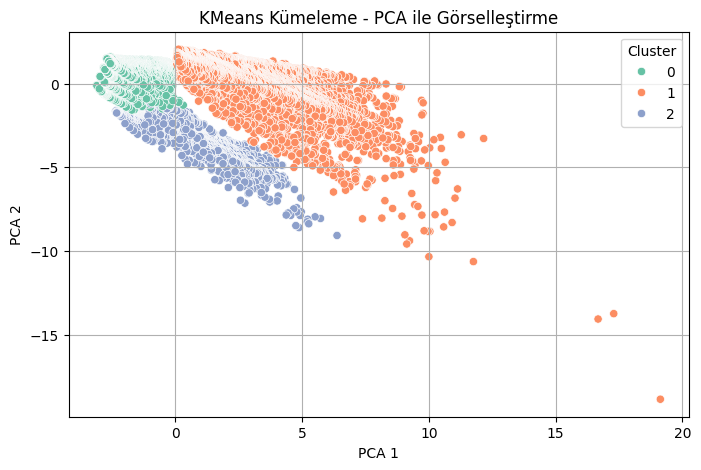

In [15]:
# Kümeleme sonuçlarını özetleyelim
print("Küme başına ortalama değerler:")
print(df_cleaned.groupby('Cluster').mean().round(2))

# İstersen PCA ile kümeleri görselleştirdim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(8,5))
sns.scatterplot(x=df_pca[:,0], y=df_pca[:,1], hue=df_cleaned['Cluster'], palette='Set2')
plt.title('KMeans Kümeleme - PCA ile Görselleştirme')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()
